<a href="https://colab.research.google.com/github/Lyra7417/Anomaly_Detection/blob/master/Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['CV.pdf',
 'Measuring_Gender_Bias_in_Citations.pdf',
 'Colab Notebooks',
 'testSet3.txt',
 'Gassian_dataset',
 'data1.mat']

[14.06411334 15.02441479] [0.93434723 0.8506542 ]
1000
在交叉验证数据集上得到的最好的epsilon是：1.248227e-03
对应的F1Score值为：1.000000


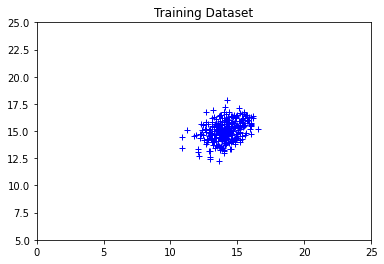

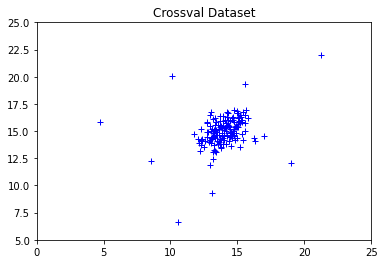

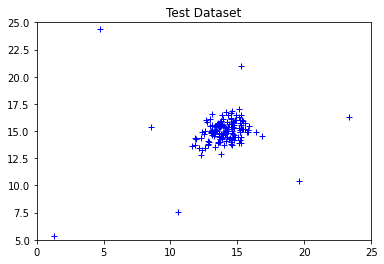

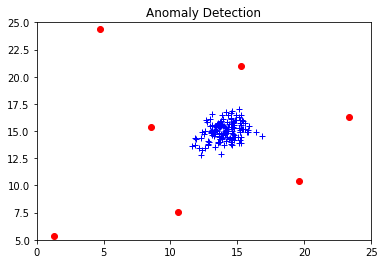

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from scipy import io as spio
import warnings
warnings.filterwarnings('ignore')

#异常检测
def AnomalyDetection():
  train_data = np.loadtxt('Gassian_dataset/train.txt')
  crossval_data_X, crossval_data_y = TXTtoArray('Gassian_dataset/crossval.txt')
  test_data = np.loadtxt('Gassian_dataset/test.txt')

  mu, sigma2 = estimateGaussian(train_data)
  print(mu, sigma2)

  p_cv = multivariateGaussian(crossval_data_X, mu ,sigma2)
  epsilon, F1 = SelectThreshold(crossval_data_y, p_cv)
  print(u'在交叉验证数据集上得到的最好的epsilon是：%e'%epsilon)
  print(u'对应的F1Score值为：%f'%F1)

  p = multivariateGaussian(test_data, mu, sigma2)
  outliers = np.where(p < epsilon)

  plt.figure(1)
  plt.title('Training Dataset')
  plt.plot(train_data[:,0], train_data[:,1],'b+')
  plt.xlim(0, 25)
  plt.ylim(5, 25)
  plt.show()

  plt.figure(2)
  plt.title('Crossval Dataset')
  plt.plot(crossval_data_X[:,0], crossval_data_X[:,1],'b+')
  plt.xlim(0, 25)
  plt.ylim(5, 25)
  plt.show()

  plt.figure(3)
  plt.title('Test Dataset')
  plt.plot(test_data[:,0], test_data[:,1],'b+')
  plt.xlim(0, 25)
  plt.ylim(5, 25)
  plt.show() 
  
  plt.figure(4)
  plt.title('Anomaly Detection')
  plt.plot(test_data[:,0],test_data[:,1],'b+')
  plt.plot(test_data[outliers,0],test_data[outliers,1],'ro')  #把异常点标记红色
  plt.xlim(0, 25)
  plt.ylim(5, 25)
  plt.show()


#参数估计函数,求均值和方差
def estimateGaussian(data):
  mu = np.mean(data, axis=0)     #axis=0表示列，求每列的均值
  sigma2 = np.var(data, axis=0)   #求每列的方差
  return mu,sigma2

#多元高斯分布函数
def multivariateGaussian(data, mu, sigma2):
  cov = np.cov(data.T)
  p = multivariate_normal(mean=mu, cov=cov)
  return p.pdf(data)

def SelectThreshold(yval, pval):
    num = 0
    bestEpsilon = 0.
    bestF1 = 0.
    F1 = 0.
    step = (np.max(pval)-np.min(pval))/1000
    
    for epsilon in np.arange(np.min(pval),np.max(pval),step):
        num += 1
        cvPrecision = pval<epsilon
        tp = np.sum((cvPrecision == 1) & (yval == 1).ravel()).astype(float)  
        fp = np.sum((cvPrecision == 1) & (yval == 0).ravel()).astype(float)
        fn = np.sum((cvPrecision == 0) & (yval == 1).ravel()).astype(float)
        precision = tp/(tp+fp)  #准确度
        recision = tp/(tp+fn)   #召回率
        F1 = (2*precision*recision)/(precision+recision)  #F1Score计算公式
        if F1 > bestF1:  
            bestF1 = F1
            bestEpsilon = epsilon
    print(num)
    return bestEpsilon, bestF1

def TXTtoArray(TXTfile):
  file = open(TXTfile)
  file_list = file.readlines() 
  Xval_lists = []
  yval_lists = []
  for string in file_list:
      string = string.split()
      Xval_lists.append(string[0:2])
      yval_lists.append(string[2])
      Xval = np.array(Xval_lists) 
      yval = np.array(yval_lists)
      Xval= Xval.astype(float)
      yval= yval.astype(float)
  return Xval, yval


if __name__ == '__main__':
    AnomalyDetection()